# Tutorial: Kirchhoff plate

This tutorial demonstrates the solution of a more complicated problem
with multiple boundary conditions and a fourth-order differential operator. We
consider the [Kirchhoff plate bending problem](https://en.wikipedia.org/wiki/Kirchhoff%E2%80%93Love_plate_theory>) which
finds its applications in solid mechanics. For a stationary plate of constant
thickness $d$, the governing equation reads: find the deflection $u
: \Omega \rightarrow \mathbb{R}$ that satisfies

$$
    \frac{Ed^3}{12(1-\nu^2)} \Delta^2 u = f, \quad \text{in $\Omega$},
$$

where $\Omega = (0,1)^2$, $f$ is a perpendicular force,
$E$ and $\nu$ are material parameters.
In this example, we analyse a $1\,\text{m}^2$ plate of steel with thickness $d=0.1\,\text{m}$.
The Young's modulus of steel is $E = 200 \cdot 10^9\,\text{Pa}$ and Poisson
ratio $\nu = 0.3$.

In reality, the operator

$$
    \frac{Ed^3}{12(1-\nu^2)} \Delta^2 
$$

is a combination of multiple first-order operators:

$$
    \boldsymbol{K}(u) = - \boldsymbol{\varepsilon}(\nabla u), \quad \boldsymbol{\varepsilon}(\boldsymbol{w}) = \frac12(\nabla \boldsymbol{w} + \nabla \boldsymbol{w}^T),
$$

$$
    \boldsymbol{M}(u) = \frac{d^3}{12} \mathbb{C} \boldsymbol{K}(u), \quad \mathbb{C} \boldsymbol{T} = \frac{E}{1+\nu}\left( \boldsymbol{T} + \frac{\nu}{1-\nu}(\text{tr}\,\boldsymbol{T})\boldsymbol{I}\right),
$$

where $\boldsymbol{I}$ is the identity matrix. In particular,

$$
    \frac{Ed^3}{12(1-\nu^2)} \Delta^2 u = - \text{div}\,\textbf{div}\,\boldsymbol{M}(u).
$$

There are several boundary conditions that the problem can take.
The *fully clamped* boundary condition reads

$$
    u = \frac{\partial u}{\partial n} = 0.
$$

Moreover, the *simply supported* boundary condition reads

$$
    u = 0, \quad M_{nn}(u)=0,
$$

where $M_{nn} = \boldsymbol{n} \cdot (\boldsymbol{M} \boldsymbol{n})$.
Finally, the *free* boundary condition reads

$$
    M_{nn}(u)=0, \quad V_{n}(u)=0,
$$

where $V_n = \boldsymbol{V} \cdot \boldsymbol{n}$ and
$\boldsymbol{V}$ is the [Kirchhoff shear force](https://arxiv.org/pdf/1707.08396.pdf). The exact
definition is not needed here as this boundary condition is a
natural one.

The correct weak formulation for the problem is: find $u \in V$ such that

$$
    (\boldsymbol{M}(u),\boldsymbol{K}(v)) = (f, v) \quad \forall v \in V,
$$

where $V$ is now a subspace of $H^2$ with the essential boundary
conditions for $u$ and $\frac{\partial u}{\partial n}$.

Instead of constructing a subspace for $H^2$, we discretise
the problem using the non-conforming Morley finite element which
is a piecewise quadratic $C^0$ element.  We begin by
creating a simple symmetric mesh for the unit square.

In [11]:
from skfem import *
import numpy as np
%matplotlib inline

m = MeshTri.init_symmetric()
m.refine(3)

After creating the mesh, we evaluate the finite element basis at the global
quadrature points. We demonstrate
the extended syntax of `skfem.assembly.InteriorBasis`
constructor which allows the user to input an object of type
`skfem.mapping.Mapping` and the integration order as
optional parameters:

In [12]:
e = ElementTriMorley()
mapping = MappingAffine(m)
ib = InteriorBasis(m, e, mapping, 2)

The integration order refers to the highest order of exactly integrated
polynomials. In this example we choose integration order equal to two, which means that quadratic polynomials can be integrated exactly.
This is required in the right hand side linear form.

For simplicity, the rather complicated bilinear form $(\boldsymbol{M}(u), \boldsymbol{K}(v))$ can be written in several parts:

In [13]:
@bilinear_form
def bilinf(u, du, ddu, v, dv, ddv, w):
    d = 0.1
    E = 200e9
    nu = 0.3

    def C(T):
        trT = T[0,0] + T[1,1]
        return np.array([[E/(1.0+nu)*(T[0, 0]+nu/(1.0-nu)*trT), E/(1.0+nu)*T[0, 1]],
                         [E/(1.0+nu)*T[1, 0], E/(1.0+nu)*(T[1, 1]+nu/(1.0-nu)*trT)]])

    def Eps(ddw):
        return np.array([[ddw[0][0], ddw[0][1]],
                         [ddw[1][0], ddw[1][1]]])

    def ddot(T1, T2):
        return T1[0, 0]*T2[0, 0] +\
               T1[0, 1]*T2[0, 1] +\
               T1[1, 0]*T2[1, 0] +\
               T1[1, 1]*T2[1, 1]

    return d**3/12.0*ddot(C(Eps(ddu)), Eps(ddv))

As loading, we shall consider a distributed force of $1\,\text{MPa}$,
i.e. $f=10^6\,\text{Pa}$.


In [5]:
@linear_form
def linf(v, dv, ddv, w):
    return 1e6*v

Assembling the stiffness matrix and the load vector
is now two calls to `skfem.assembly.asm`:

In [6]:
K = asm(bilinf, ib)
f = asm(linf, ib)

Next we demonstrate setting different boundary conditions on different parts of
the boundary.  An easy way is to create `skfem.mesh.Submesh` objects
for each boundary:

In [7]:
boundary = {
        'left':  m.submesh(lambda x, y: x==0),
        'right': m.submesh(lambda x, y: x==1),
        'top':   m.submesh(lambda x, y: y==1),
        }

The corresponding degree-of-freedom numbers (i.e. rows and columns
of the stiffness matrix) can be found using
`skfem.assembly.GlobalBasis.get_dofs`.

In [8]:
dofs = ib.get_dofs(boundary)

D = np.concatenate((
        dofs['left'].nodal['u'],
        dofs['left'].facet['u_n'],
        dofs['right'].nodal['u'],
        dofs['top'].nodal['u'],
        ))

The solution of the linear system is now done similarly as in the
Poisson example.

In [9]:
I = ib.complement_dofs(D)
x = np.zeros_like(f)
x[I] = solve(*condense(K, f, I=I))

Morley element uses quadratic basis
functions, and we cannot fully appreciate the discrete solution
unless we refine the mesh for visualisation. This is done using
`skfem.assembly.InteriorBasis.refinterp` as follows:

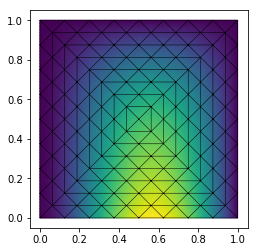

In [14]:
M, X = ib.refinterp(x, 3)
ax = m.draw()
M.plot(X, smooth=True, ax=ax)